<Axes: xlabel='Date'>

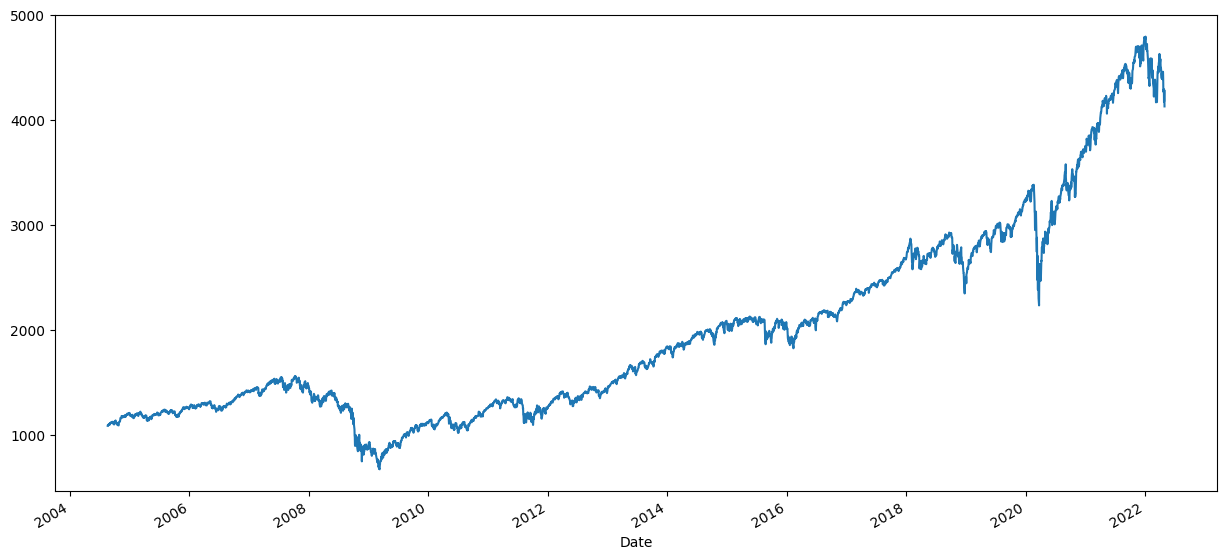

In [1]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd

start = "2004-08-19"
test_start = "2022-05-01"
interval = "1d"
gspc = yf.Ticker("^GSPC")

data = gspc.history(start=start, interval=interval, end=test_start)

data = data.dropna()

df = data[['Close']]
df['Close'].plot(figsize=(15, 7))

In [2]:
from statsmodels.tsa.stattools import adfuller

adf_res = adfuller(df['Close'], autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))

p-Values:0.9951631477883771


C:\Users\napat\AppData\Local\Temp\ipykernel_6460\1849440833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_diff'] = df['Close'].diff(1)


p-Values:9.030323885012121e-26


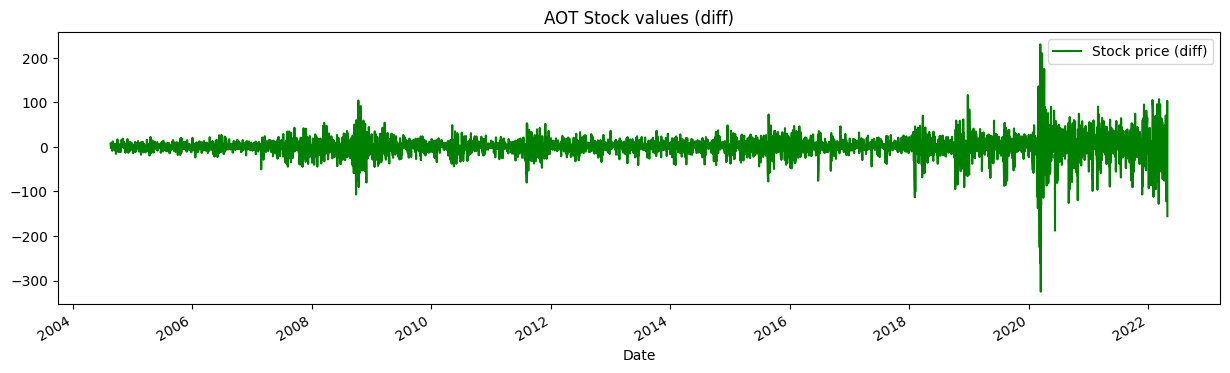

In [3]:
df['Close_diff'] = df['Close'].diff(1)
df['Close_diff'].plot(color = 'green', figsize = (15,4))
plt.legend(['Stock price (diff)'])
plt.title('AOT Stock values (diff)')

adf_res = adfuller(df['Close_diff'].dropna(), autolag = 'AIC')
print('p-Values:' + str(adf_res[1]))

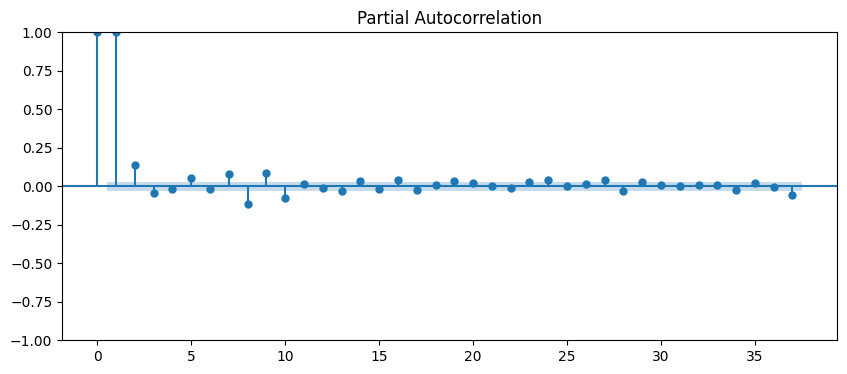

In [4]:
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_pacf(df['Close'].dropna(), method = 'ols')
df_pacf = pacf(df['Close'].dropna(), method = 'ols')

In [5]:
import numpy as np

for i in range(0, len(df_pacf)):
    if df_pacf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('p =',i - 1)
        break

p = 2


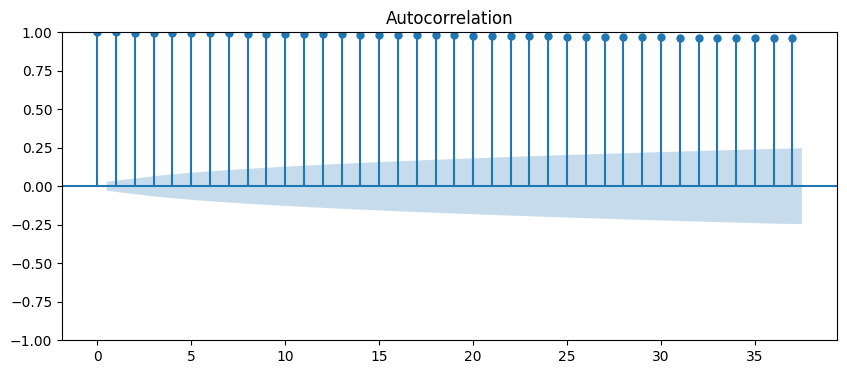

In [6]:

#Moving Average (q)
from statsmodels.graphics.tsaplots import  plot_acf
from statsmodels.tsa.stattools import acf

plt.rcParams.update({'figure.figsize':(10,4)})
plot_acf(df['Close'], fft = True)
df_acf = acf(df['Close'], fft = True)

In [7]:
for i in range(0, len(df_acf)):
    if df_acf[i] < 1.96 / np.sqrt(len(df['Close'])):
        print('q=', i - 1)
        break

In [8]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
p = q = [1, 2, 3]
d = [1] 
pdq = list(itertools.product(p, d, q))

aic = []

for param in pdq:
    try:
        model = ARIMA(df['Close'].dropna(), order = param)
        results = model.fit()
        a = (results.aic, param)
        aic.append(a)
    except:
        continue
aic

c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

[(41023.70742882321, (1, 1, 1)),
 (41021.16699896799, (1, 1, 2)),
 (41020.74127233618, (1, 1, 3)),
 (41022.63328753035, (2, 1, 1)),
 (40881.50793599167, (2, 1, 2)),
 (41018.38478743698, (2, 1, 3)),
 (40956.803464729455, (3, 1, 1)),
 (41017.600886956905, (3, 1, 2)),
 (40884.562891038266, (3, 1, 3))]

In [9]:
min_order = min(aic)[1]
print('Min AIC:', min(aic))

# aic is (value, (p, d, q))
# p is AR, q is MA, r is difference

# AR is the number of lags of Y to be used as predictors.
# what is number of lags meaning? how many previous values of Y are used to predict the current value of Y
# which mean next stock price is depend on previous stock price 
# what if p is 0? it means that the current value of Y is not dependent on the previous values of Y

# q is the number of lagged forecast errors that should go into the ARIMA model
# what is the meaning of q? how many previous forecast errors are used to predict the current value of Y
# which mean the next stock price is depend on previous forecast errors
# what if q is 0? it means that the current value of Y is not dependent on the previous forecast errors

# d is the number of differencing required to make the time series stationary
# what is the meaning of d? how many times the raw observations are differenced to make the time series stationary
# what if d is 0? it means that the time series is already stationary

# what if q is 0 and p is 0? it means that the current value of Y is not dependent on the previous values of Y and previous forecast errors
# what current y depend on if q and p is 0? ans: random walk (equation: Y(t) = c + e(t))

# what is e(t)? ans: error term at time t
# how we know e(t)? ans: we can't know e(t) because it is random
# which mean e(t) is random variable
# what is c? ans: constant term

# arima 1 1 1 equation: Y(t) = c + Y(t-1) + e(t-1) + e(t)


Min AIC: (40881.50793599167, (2, 1, 2))


In [10]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import torch

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def RMSE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.sqrt(torch.mean((pred - y) ** 2)))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def directional_accuracy(Y_actual, Y_predicted):
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.sign(np.diff(Y_predicted))
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy

def directional_accuracy_baseline(Y_actual): # only guess up or down based on previous day
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.roll(actual_changes, 1)
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy



In [11]:
directional_accuracy_baseline(df['Close'])

47.22783389450056

c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 4456
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -20498.891
Date:                Thu, 08 Aug 2024   AIC                          41007.782
Time:                        02:59:21   BIC                          41039.791
Sample:                             0   HQIC                         41019.067
                               - 4456                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0461      0.016    -67.141      0.000      -1.077      -1.016
ar.L2         -0.1606      0.005    -33.150      0.000      -0.170      -0.151
ma.L1         -0.0869      0.016     -5.296      0.0

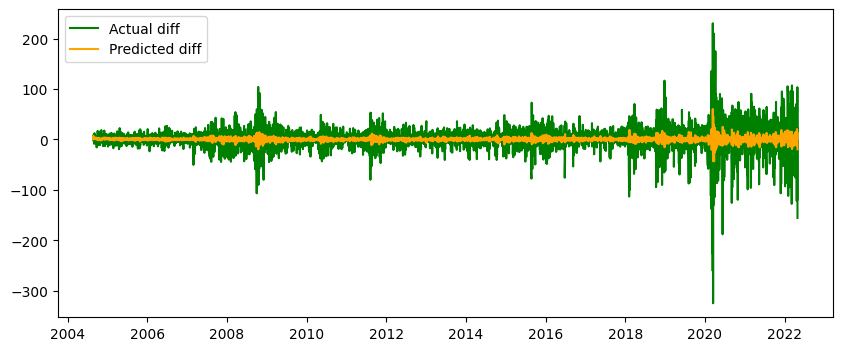

In [12]:
model = ARIMA(df['Close_diff'], order = min_order)
results = model.fit()
print(results.summary())

#Prediction
plt.figsize = (15,4)
plt.plot(df['Close_diff'], color = 'green', label = 'Actual diff')
plt.plot(results.predict(), color= 'orange', label = 'Predicted diff')
plt.legend()

In [13]:
# print mse
from sklearn.metrics import mean_squared_error
df['Close_diff'].fillna(0, inplace = True)
print('MSE:', mean_squared_error(df['Close_diff'], results.predict()))


MSE: 579.1211582989606


C:\Users\napat\AppData\Local\Temp\ipykernel_6460\3559543743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close_diff'].fillna(0, inplace = True)


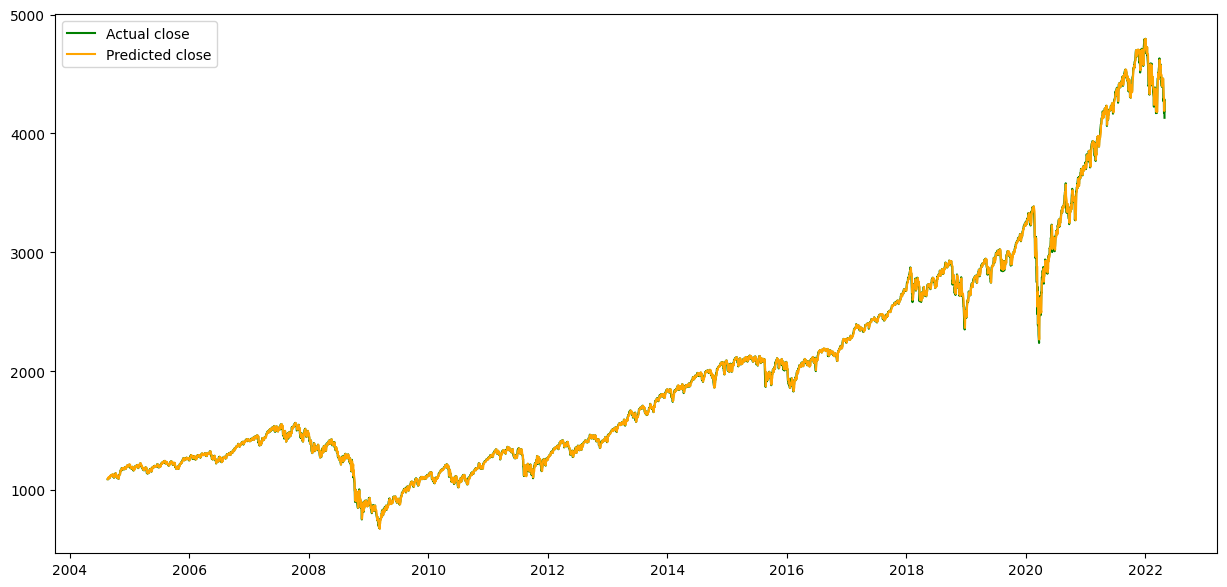

In [14]:
import pandas as pd

prediction = pd.DataFrame(columns=['Predicted'])
prediction['Predicted'] = results.predict()
# print(prediction)
df_pred = pd.merge(df, prediction, how = 'left', left_index = True, right_index = True)

df_pred['Predicted_close'] = df_pred['Close'] + df_pred['Predicted'].shift(-1)
df_pred['Predicted_close'] = df_pred['Predicted_close'].shift(1).fillna(df['Close'])
plt.figure(figsize=(15, 7))
plt.plot(df_pred['Close'], color = 'green', label = 'Actual close')
plt.plot(df_pred['Predicted_close'], color='orange', label = 'Predicted close')
plt.legend()


In [16]:
print("Error on train data")
print('MSE:', mean_squared_error(df['Close'], df_pred['Predicted_close']))
print('SMAPE:', SMAPE(df_pred['Predicted_close'], df['Close']))
print('MAE:', MAE(df_pred['Predicted_close'], df['Close']))
print('RMSE:', RMSE(df_pred['Predicted_close'], df['Close']))
print('Directional Accuracy:', directional_accuracy(df['Close'], df_pred['Predicted_close']))

Error on train data
MSE: 579.1211582989605
SMAPE: 0.7728605180905627
MAE: 14.629983003448583
RMSE: 24.064936282877635
Directional Accuracy: 48.058361391694724


C:\Users\napat\AppData\Local\Temp\ipykernel_6460\3812829462.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Local\Temp\ipykernel_6460\3812829462.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
C:\Users\napat\AppData\Local\Temp\ipykernel_6460\3812829462.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Lo

<Axes: xlabel='Date'>

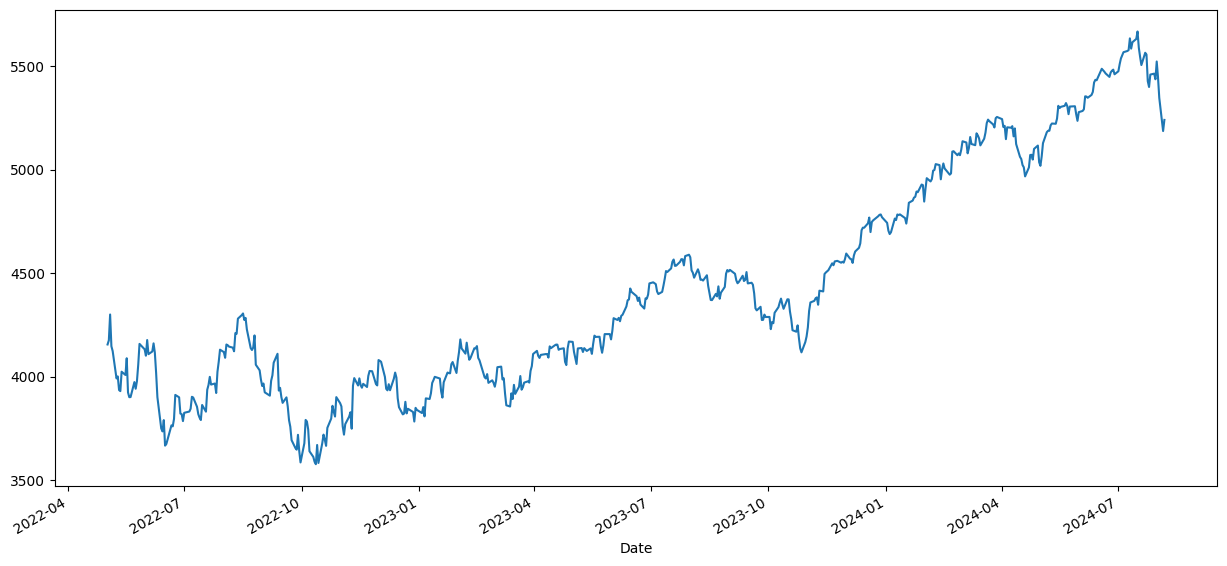

In [17]:
data_test = gspc.history(start=test_start, interval=interval)
data_test = data_test.dropna()
df_test = data_test[['Close']]
df_test['Close'].plot(figsize=(15, 7))


      Predicted
4456  24.213403
4457   1.876814
4458  -3.636258
4459   5.718708
4460  -3.181636
4461   4.626020
4462  -2.111637
4463   3.682250
4464  -1.296266
4465   2.980916
4466  -0.693598
4467   2.463140
4468  -0.248778
4469   2.080999
4470   0.079515
4471   1.798967
4472   0.321806
4473   1.590817
4474   0.500625
4475   1.437197
4476   0.632599
4477   1.323819
4478   0.730000
4479   1.240143
4480   0.801885
4481   1.178387
4482   0.854939
4483   1.132810
4484   0.894094
4485   1.099172
4486   0.922992
4487   1.074346
4488   0.944320
4489   1.056024
4490   0.960060
4491   1.042501
4492   0.971677
4493   1.032521
4494   0.980251
4495   1.025156


c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\napat\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


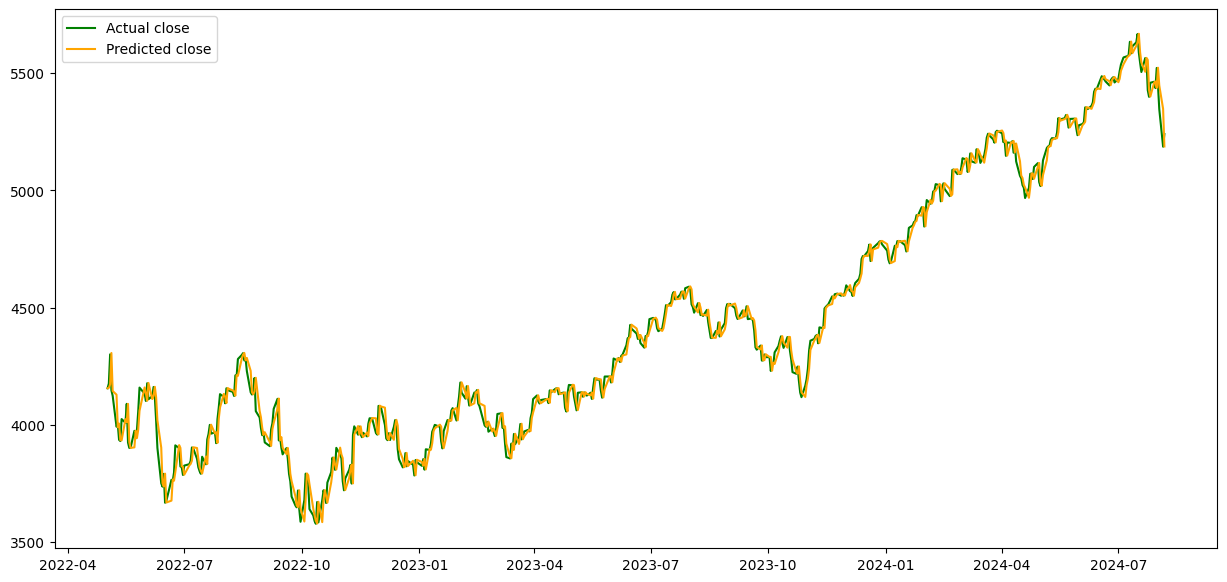

In [18]:
# prediction by arima without seen the future
prediction = pd.DataFrame(columns=['Predicted'])
print()
df_all = pd.concat([df, df_test])
prediction['Predicted'] = results.predict(start = len(df), end = len(df_all) - 1)

print(prediction[:40])

df_test_pred = df_test["Close"].copy()
df_test_pred = df_test_pred.reset_index()
df_test_pred["Predicted"] = prediction["Predicted"].values
df_test_pred.set_index("Date", inplace=True)

df_test_pred['Predicted_close'] = df_test_pred['Close'] + df_test_pred['Predicted'].shift(-1)
df_test_pred['Predicted_close'] = df_test_pred['Predicted_close'].shift(1).fillna(df_test['Close'])
plt.figure(figsize=(15, 7))
plt.plot(df_test_pred['Close'], color = 'green', label = 'Actual close')
plt.plot(df_test_pred['Predicted_close'], color='orange', label = 'Predicted close')
plt.legend()



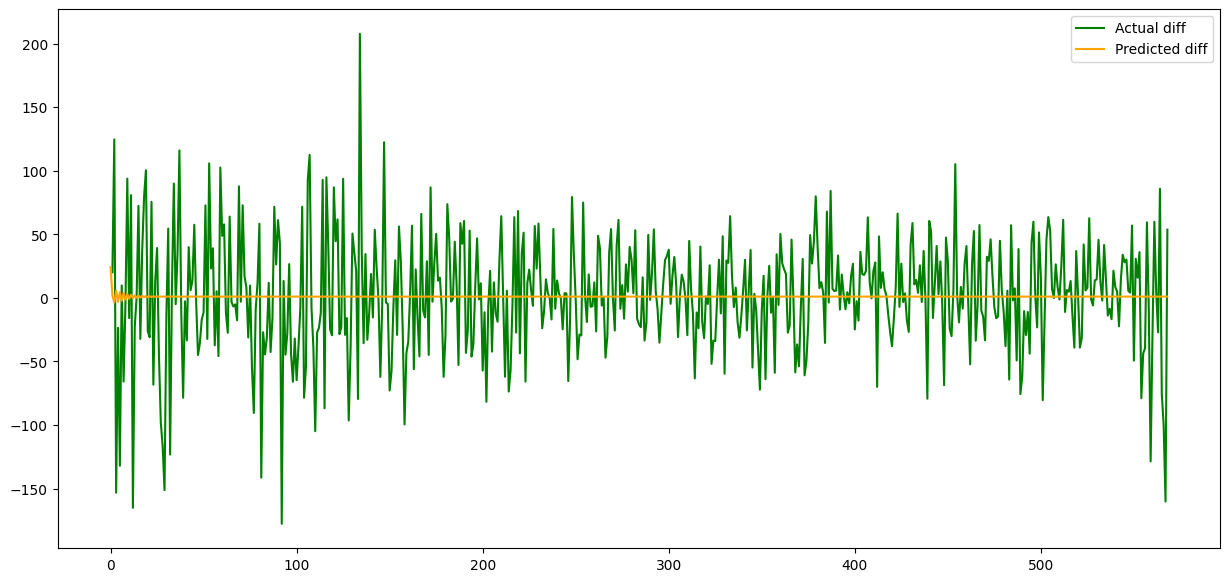

In [19]:
# plot between real_diff and predicted_diff
plt.figure(figsize=(15, 7))
df_test_pred.reset_index(drop=True, inplace=True)
prediction.reset_index(drop=True, inplace=True)
df_test_pred['Close_diff'] = df_test_pred['Close'].diff(1)
df_test_pred['Predicted_diff'] = prediction['Predicted']
plt.plot(df_test_pred['Close_diff'], color = 'green', label = 'Actual diff')
plt.plot(df_test_pred['Predicted_diff'], color='orange', label = 'Predicted diff')
plt.legend()



In [20]:
df_test_pred

,Close,Predicted,Predicted_close,Close_diff,Predicted_diff
0,4155.379883,24.213403,4155.379883,NaN,24.213403
1,4175.479980,1.876814,4157.256697,20.100098,1.876814
2,4300.169922,-3.636258,4171.843722,124.689941,-3.636258
3,4146.870117,5.718708,4305.888630,-153.299805,5.718708
4,4123.339844,-3.181636,4143.688481,-23.530273,-3.181636
...,...,...,...,...,...
564,5522.299805,1.004405,5437.444346,85.859863,1.004405
565,5446.680176,1.004405,5523.304210,-75.619629,1.004405
566,5346.560059,1.004405,5447.684581,-100.120117,1.004405
567,5186.330078,1.004405,5347.564464,-160.229980,1.004405


In [53]:
df_test_pred['Predicted_close']

Date
2023-05-01 00:00:00+00:00    28091.568359
2023-05-02 00:00:00+00:00    28100.848723
2023-05-03 00:00:00+00:00    28689.660924
2023-05-04 00:00:00+00:00    29015.483857
2023-05-05 00:00:00+00:00    28856.844597
                                 ...     
2024-05-11 00:00:00+00:00    60801.911129
2024-05-12 00:00:00+00:00    60802.885153
2024-05-13 00:00:00+00:00    61457.528317
2024-05-14 00:00:00+00:00    62910.623434
2024-05-15 00:00:00+00:00    61561.922849
Name: Predicted_close, Length: 381, dtype: float64

In [54]:
print("error on test data:")
print('SMAPE:', SMAPE(df_test_pred['Predicted_close'], df_test['Close']))
print('MAE:', MAE(df_test_pred['Predicted_close'], df_test['Close']))
print('RMSE:', RMSE(df_test_pred['Predicted_close'], df_test['Close']))
print('Directional Accuracy:', directional_accuracy(df_test['Close'], df_test_pred['Predicted_close']))


error on test data:
SMAPE: 1.661408227931098
MAE: 744.4083475409781
RMSE: 1212.2089041924419
Directional Accuracy: 46.31578947368421


C:\Users\napat\AppData\Local\Temp\ipykernel_23248\3812829462.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData\Local\Temp\ipykernel_23248\3812829462.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(y)
C:\Users\napat\AppData\Local\Temp\ipykernel_23248\3812829462.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = torch.tensor(pred)
C:\Users\napat\AppData

In [55]:
def buy_sell_stock_v2(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(len(prices)-1):
        if  holding and real[i] > prices[i + 1] :
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and real[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    print(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

def plot_stock_prices(prices,real, buy_days, sell_days):
    plt.figure(figsize=(30, 10))
    plt.plot(prices.index, prices.values, label='Pred Stock Prices')
    plt.plot(real.index, real.values, label='Real Stock Prices')
    plt.scatter(buy_days, prices.loc[buy_days], color='green', marker='^', label='Buy')
    plt.scatter(sell_days, prices.loc[sell_days], color='red', marker='v', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Buy/Sell Signals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [56]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock_v2( df_test_pred['Predicted_close'], df_test['Close'] )
# print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
# print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

[]


C:\Users\napat\AppData\Local\Temp\ipykernel_23248\2019213181.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif not holding and real[i] < prices[i + 1]:
C:\Users\napat\AppData\Local\Temp\ipykernel_23248\2019213181.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_bought = prices[i]
C:\Users\napat\AppData\Local\Temp\ipykernel_23248\2019213181.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  real_current_bought =

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plot_stock_prices( df_test_pred['Predicted_close'], df_test['Close'], buy_days, sell_days)

NameError: name 'buy_days' is not defined

In [ ]:
def buy_sell_stock(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(1, len(prices)-1):
        if  holding and prices[i] > prices[i - 1] and prices[i] > prices[i + 1]:
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [59]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock( df_test_pred['Predicted_close'], df_test['Close'] )
# print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
# print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

real_return = 55.20341074759798 %
max_real_return = 18.930635101088832 %


C:\Users\napat\AppData\Local\Temp\ipykernel_23248\1538798444.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif not holding and prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
C:\Users\napat\AppData\Local\Temp\ipykernel_23248\1538798444.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_bought = prices[i]
C:\Users\napat\AppData\Local\Temp\ipykernel_23248\1538798444.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

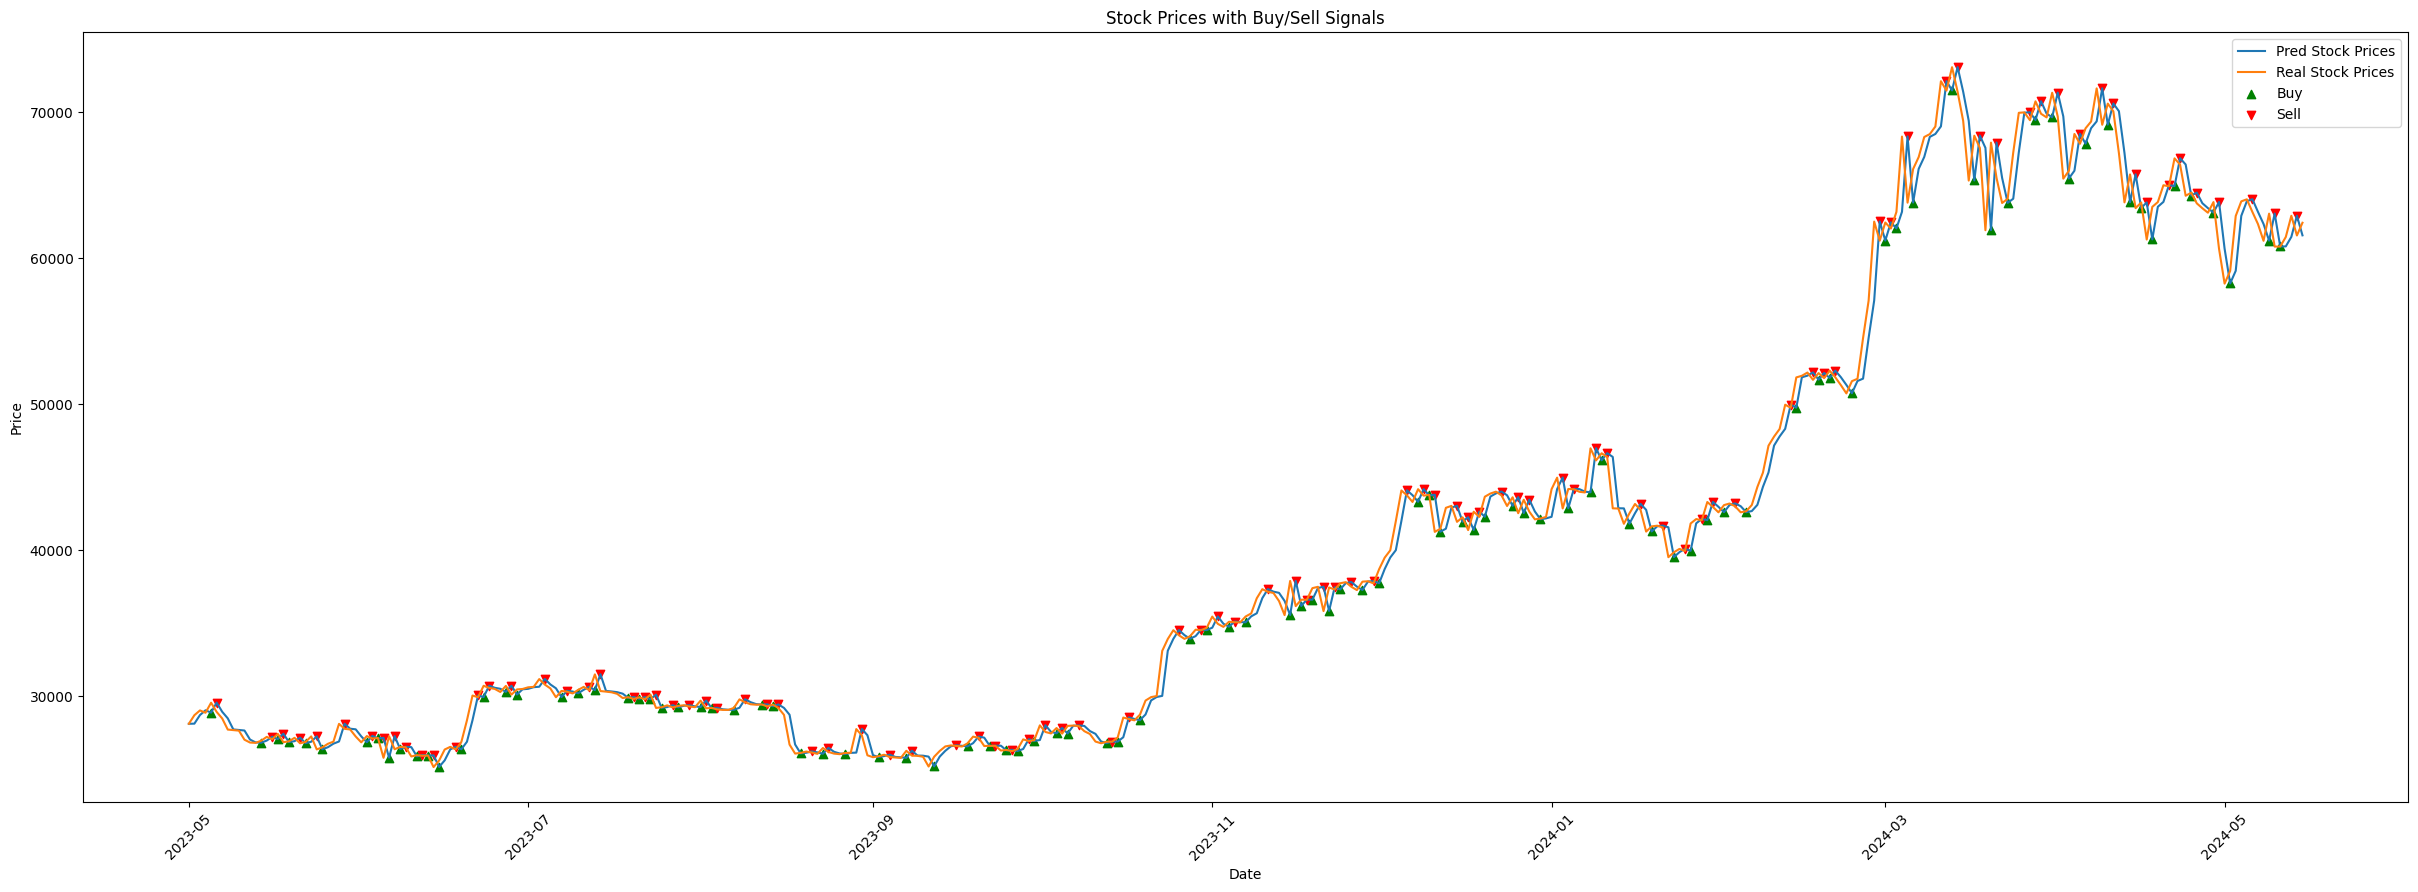

In [60]:
plot_stock_prices( df_test_pred['Predicted_close'], df_test['Close'], buy_days, sell_days)

In [58]:
df_test_pred

,Close,Predicted,Predicted_close
Date,,,
2023-05-01 00:00:00+00:00,28091.568359,8.126135,28091.568359
2023-05-02 00:00:00+00:00,28680.537109,9.280363,28100.848723
2023-05-03 00:00:00+00:00,29006.308594,9.123815,28689.660924
2023-05-04 00:00:00+00:00,28847.710938,9.175263,29015.483857
2023-05-05 00:00:00+00:00,29534.384766,9.133660,28856.844597
...,...,...,...
2024-05-11 00:00:00+00:00,60793.710938,9.133786,60801.911129
2024-05-12 00:00:00+00:00,61448.394531,9.174216,60802.885153
2024-05-13 00:00:00+00:00,62901.449219,9.133786,61457.528317


In [ ]:
df_test

,Close
Date,
2023-05-01 00:00:00+00:00,28091.568359
2023-05-02 00:00:00+00:00,28680.537109
2023-05-03 00:00:00+00:00,29006.308594
2023-05-04 00:00:00+00:00,28847.710938
2023-05-05 00:00:00+00:00,29534.384766
...,...
2024-05-11 00:00:00+00:00,60793.710938
2024-05-12 00:00:00+00:00,61448.394531
2024-05-13 00:00:00+00:00,62901.449219
